In [1]:
import pandas as pd
from matplotlib.pyplot import ylabel
import mplfinance as mpf
import rbot


In [2]:
class Agent:
    def __init__(self, param_K=1.6):
        self.K = param_K                           # パラメターKを設定する。

    def on_clock(self, time_ms: int, session):# 指定時間毎に呼び出される（今回は２H相当時間毎）
        ohlcv_array = session.ohlcv(60*60*2, 6)     # 最新足０番目　＋　５本の足を取得。 最新は６番目。
        ohlcv_df = rbot.array_to_df(ohlcv_array)    # ndarrayをDataFrameへ変換

        if len(ohlcv_df.index) < 6:                 # データが過去６本分そろっていない場合はなにもせずリターン
            return 

        ohlcv_df["range"] = ohlcv_df["high"] - ohlcv_df["low"]      # レンジを計算

        ohlcv_latest = ohlcv_df[-2:-1]     # 最新足１本
        ohlcv_last_5 = ohlcv_df[:-2]       # 過去５本足

        range_width = ohlcv_last_5["range"].mean()      #　過去５本足のレンジの平均値

        # Long/Short判定
        detect_short = range_width * self.K < ohlcv_latest["high"][0] - ohlcv_latest["open"][0]
        detect_long  = range_width * self.K < ohlcv_latest["open"][0] - ohlcv_latest["low"][0]

        #　執行方法（順報告のポジションがあったら保留。逆方向のポジションがのこっていたらドテン）
        if detect_long: #long判定
            if not session.long_pos_size: #　既存のポジションがないこと
                if not session.short_pos_size:  # ショートのポジションがない場合は通常。ある場合はドテン。
                        #rbot.Order("Buy"|"Sell", 価格　　　　　　,数量（ドル）,オーダー有効期間(秒), コメント（任意の文字列）)
                    return rbot.Order("Buy", session.buy_edge_price, 100, 600, "open long")    
                else:
                    return rbot.Order("Buy", session.buy_edge_price, 200, 600, "DOTEN Long")    
            else:
                pass

        if detect_short:
            if not session.short_pos_size:
                if not session.long_pos_size:
                    return rbot.Order("Sell", session.sell_edge_price, 100, 600, "open short") 
                else:
                    return rbot.Order("Sell", session.sell_edge_price, 200, 600, "DOTEN Short") 
            else:
                pass
  


In [3]:
bb = rbot.DummyBb()             # ダミーBybitクラス作成
bb.log_load(100)                # 過去100日分データをロード

In [4]:
agent = Agent()                    # 検証するクラスのインスタンス化

# bb.debug_loop_count = 1          # on_clockを1回呼び出したら終了。でバック時にコメントアウトする
result = bb.run(agent, 60*60*2)    # バックテスト実行（呼び出し周期を秒で指定。60x60x2は２時間毎）

backtest_df = rbot.result_to_df(result)   # バックテストの結果をDataFrameに変換

call back tick by 7200[sec]


In [5]:
backtest_df

,timestamp,order_id,sub_id,order_type,post_only,status,open_price,close_price,size,volume,profit,fee,total_profit,pos_change,message,sum_profit,sum_pos
create_time,,,,,,,,,,,,,,,,,
2022-03-21 05:59:59+00:00,2022-03-21 06:01:06+00:00,0000-0001,0,Buy,True,Open,40941.0,0.0,100.0,0.002443,0.000000,0.06,-0.060000,100.0,open long,-0.060000,100.0
2022-03-22 05:59:59+00:00,2022-03-22 06:00:01+00:00,0000-0002,0,Sell,True,Close,40941.0,42870.0,100.0,0.002333,-4.499650,0.06,-4.559650,-100.0,DOTEN Short,-4.619650,0.0
2022-03-22 05:59:59+00:00,2022-03-22 06:00:01+00:00,0000-0002,1,Sell,True,Open,42870.0,0.0,100.0,0.002333,0.000000,0.06,-0.060000,-100.0,DOTEN Short,-4.679650,-100.0
2022-03-30 03:59:57+00:00,2022-03-30 04:00:00+00:00,0000-0003,0,Buy,True,Close,42870.0,47435.0,100.0,0.002108,9.623696,0.06,9.563696,100.0,DOTEN Long,4.884045,0.0
2022-03-30 03:59:57+00:00,2022-03-30 04:00:00+00:00,0000-0003,1,Buy,True,Open,47435.0,0.0,100.0,0.002108,0.000000,0.06,-0.060000,100.0,DOTEN Long,4.824045,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13 03:59:57+00:00,2022-06-13 04:00:01+00:00,0000-0050,1,Buy,True,Open,25456.0,0.0,100.0,0.003928,0.000000,0.06,-0.060000,100.0,DOTEN Long,-1.443793,100.0
2022-06-18 23:59:59+00:00,2022-06-19 00:00:08+00:00,0000-0051,0,Sell,True,Close,25456.0,18941.5,100.0,0.005279,34.392736,0.06,34.332736,-100.0,DOTEN Short,32.888943,0.0
2022-06-18 23:59:59+00:00,2022-06-19 00:00:08+00:00,0000-0051,1,Sell,True,Open,18941.5,0.0,100.0,0.005279,0.000000,0.06,-0.060000,-100.0,DOTEN Short,32.828943,-100.0


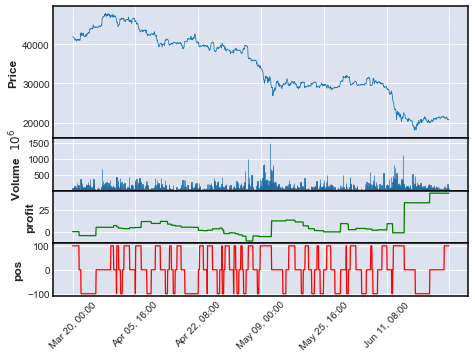

In [6]:
ohlcv = bb.ohlcv(0, bb.log_end_ms, 60*60 * 2)           # bybitオブジェクトをつかってログからOHLCVデータを生成
ohlcv_df = rbot.array_to_df(ohlcv)                      # array形式なのでDataFrameへ変換。

chart = pd.merge_asof(ohlcv_df, backtest_df, left_on="timestamp", right_on="create_time", direction="nearest")  #ohlcvへ時間軸をマージ

ap2 = [
    mpf.make_addplot(chart['sum_profit'], type='line', color='g', panel=2, ylabel="profit"),    # profitの描画
    mpf.make_addplot(chart['sum_pos'], type='line', color='r', panel=3, ylabel="pos"),          # positionの描画
]
mpf.plot(ohlcv_df, volume=True, type='line', addplot=ap2)       # 全体描画